In [8]:
# Create GAN for MDP process with two states

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tcn import TCN, tcn_full_summary


class GAN:
    def __init__(self, seq_len=16, latent_dim=25):
        # self.P = np.random.uniform(0, 1, (6, 6))
        # print(self.P, np.sum(self.P, axis=1, keepdims=True))
        # self.P = self.P / np.sum(self.P, axis=1, keepdims=True)
        self.states = [0, 1, 2, 3]
        self.actions = [0, 1, 2, 3, 4, 5, 6, 7]
        self.latent_dim = latent_dim
        self.seq_len = seq_len
        # print(self.P)
        self.build_generator()
        self.build_discriminator()
        self.build_gan()
        # print(self.P)

    def generate_real_samples(self, n_samples):
        X_total = []
        labels = []
        for i in range(n_samples):
            current_state = np.random.choice([0, 1, 2, 3])
            labels.append(current_state)
            X = []
            while len(X) < self.seq_len:
                if current_state == 0:
                    ac = np.random.choice([0, 1])
                    if ac == 0:
                        next_state = np.random.choice([0, 1], p=[0.9, 0.1])
                        if next_state == 1:
                            reward = -1
                        else:
                            reward = 1
                    else:
                        next_state = 1
                        reward = 10

                    ac = tf.keras.utils.to_categorical(ac, num_classes=8)
                    current_state_cat = tf.keras.utils.to_categorical(
                        current_state, num_classes=4
                    )
                    current_state = next_state
                    X.append(np.concatenate([current_state_cat, ac, [reward/10]]))
                elif current_state == 1:
                    ac = np.random.choice([2, 3])
                    if ac == 2:
                        next_state = np.random.choice([1, 2], p=[0.9, 0.1])
                        if next_state == 2:
                            reward = -2
                        else:
                            reward = 2
                    else:
                        next_state = 2
                        reward = 10

                    ac = tf.keras.utils.to_categorical(ac, num_classes=8)
                    current_state_cat = tf.keras.utils.to_categorical(
                        current_state, num_classes=4
                    )
                    current_state = next_state
                    X.append(np.concatenate([current_state_cat, ac, [reward/10]]))

                elif current_state == 2:
                    ac = np.random.choice([4, 5])
                    if ac == 4:
                        next_state = np.random.choice([2, 3], p=[0.9, 0.1])
                        if next_state == 3:
                            reward = -3
                        else:
                            reward = 3
                    else:
                        next_state = 3
                        reward = 10
                    ac = tf.keras.utils.to_categorical(ac, num_classes=8)
                    current_state_cat = tf.keras.utils.to_categorical(
                        current_state, num_classes=4
                    )
                    current_state = next_state
                    X.append(np.concatenate([current_state_cat, ac, [reward/10]]))
                elif current_state == 3:
                    ac = np.random.choice([6, 7])
                    if ac == 6:
                        next_state = np.random.choice([3, 0], p=[0.9, 0.1])
                        if next_state == 0:
                            reward = -4
                        else:
                            reward = 4
                    else:
                        next_state = 0
                        reward = 10

                    ac = tf.keras.utils.to_categorical(ac, num_classes=8)
                    current_state_cat = tf.keras.utils.to_categorical(
                        current_state, num_classes=4
                    )
                    current_state = next_state
                    X.append(np.concatenate([current_state_cat, ac, [reward/10]]))
            X = np.array(X)
            # X = tf.keras.utils.to_categorical(X, num_classes=6)
            X_total.append(X)
        X = np.array(X_total)
        y = np.ones((n_samples, 1)) * 0.9
        # print(X.shape, y.shape)
        labels = tf.keras.utils.to_categorical(labels, num_classes=4)
        
        return X, labels, y

    def generate_fake_samples(self, n_samples, labels):
        X = self.generator.predict([np.random.normal(0, 1, (n_samples, 25)), labels])
        y = np.zeros((n_samples, 1))
        return X, y

    def calculate_P(self, n_samples):
        labels = np.random.randint(0, 4, n_samples)
        labels = tf.keras.utils.to_categorical(labels, num_classes=4)
        X, _ = self.generate_fake_samples(n_samples, labels)
        X1 = np.argmax(X[:, :, :4], axis=2)
        X2 = np.argmax(X[:, :, 4:12], axis=2)
        X3 = X[:, :, 12]
        # X1 = np.argmax(X1, axis=1)
        # X2 = np.argmax(X2, axis=1)
        print("Probabilitity of starting position being 0:", np.mean(X1[:, 0] == 0))
        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        print("Probabilitity of starting position being 2:", np.mean(X1[:, 0] == 2))
        print("Probabilitity of starting position being 3:", np.mean(X1[:, 0] == 3))
        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )
        print(
            "Probability of action 3 being taken in state 1:", np.mean(X2[X1 == 1] == 3)
        )
        print(
            "Probability of action 4 being taken in state 2:", np.mean(X2[X1 == 2] == 4)
        )
        print(
            "Probability of action 5 being taken in state 2:", np.mean(X2[X1 == 2] == 5)
        )
        print(
            "Probability of action 6 being taken in state 3:", np.mean(X2[X1 == 3] == 6)
        )
        print(
            "Probability of action 7 being taken in state 3:", np.mean(X2[X1 == 3] == 7)
        )

    def calculate_final_P(self, n_samples):
        labels = np.random.randint(0, 4, n_samples)
        labels = tf.keras.utils.to_categorical(labels, num_classes=4)
        X, _ = self.generate_fake_samples(n_samples, labels)
        X1 = np.argmax(X[:, :, :4], axis=2)
        X2 = np.argmax(X[:, :, 4:12], axis=2)
        # X1 = np.argmax(X1, axis=1)
        # X2 = np.argmax(X2, axis=1)
        print("Probabilitity of starting position being 0:", np.mean(X1[:, 0] == 0))
        print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        print("Probabilitity of starting position being 2:", np.mean(X1[:, 0] == 2))
        print("Probabilitity of starting position being 3:", np.mean(X1[:, 0] == 3))
        print(
            "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        )
        print(
            "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        )
        print(
            "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        )
        print(
            "Probability of action 3 being taken in state 1:", np.mean(X2[X1 == 1] == 3)
        )
        print(
            "Probability of action 4 being taken in state 2:", np.mean(X2[X1 == 2] == 4)
        )
        print(
            "Probability of action 5 being taken in state 2:", np.mean(X2[X1 == 2] == 5)
        )
        print(
            "Probability of action 6 being taken in state 3:", np.mean(X2[X1 == 3] == 6)
        )
        print(
            "Probability of action 7 being taken in state 3:", np.mean(X2[X1 == 3] == 7)
        )
        ps = np.zeros((4, 8, 4))
        for i in range(n_samples):
            for j in range(self.seq_len - 1):
                ps[X1[i, j], X2[i, j], X1[i, j + 1]] += 1
        ps = ps / np.sum(ps, axis=2, keepdims=True)
        print(ps)

    # def calculate_P_real(self, n_samples):
    #     X, _ = self.generate_real_samples(n_samples)
    #     X = np.argmax(X, axis=2)
    #     P = np.zeros((6, 6))
    #     for i in range(n_samples):
    #         for j in range(self.seq_len - 1):
    #             P[X[i, j], X[i, j + 1]] += 1

    #     P = P / np.sum(P, axis=1, keepdims=True)
    #     return P

    def build_generator(self):
        # tcn_layer1 = TCN(nb_filters=500, dilations=(1,), return_sequences=True)

        # print(tcn_layer1.receptive_field)
        inp = tf.keras.layers.Input(shape=(self.latent_dim,))
        inp2 = tf.keras.layers.Input(shape=(4,))
        # inp2 
        # tmp = tf.keras.layers.Embedding(4, 4)(inp2)
        inp3 = tf.keras.layers.Concatenate()([inp, inp2])
        x = tf.keras.layers.Dense(16 * 3000)(inp3)
        x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
        x = tf.keras.layers.Reshape((16, 3000))(x)
        # inp2 = tf.keras.layers.Dense(16 * 1)(inp2)
        # inp2 = tf.keras.layers.Reshape((16, 1))(inp2)
        # x = tf.keras.layers.Concatenate()([x, inp2])
        # x = tcn_layer1(x)
        y1 = tf.keras.layers.Dense(4, activation="softmax")(x)
        y2 = tf.keras.layers.Dense(8, activation="softmax")(x)
        y3 = tf.keras.layers.Dense(1, activation="tanh")(x)
        y = tf.keras.layers.Concatenate()([y1, y2, y3])
        self.generator = tf.keras.models.Model(inputs=[inp, inp2], outputs=y)
        # self.generator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Dense(4 * 2000, input_shape=(25,)),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Reshape((4, 2000)),
        #         tf.keras.layers.Conv1DTranspose(100, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1DTranspose(50, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1DTranspose(
        #             5, 3, strides=1, padding="same", activation="sigmoid"
        #         ),
        #     ]
        # )
        # inp = tf.keras.layers.Input(shape=(25,))
        # x = self.generator(inp)
        # y1 = tf.keras.layers.Conv1DTranspose(
        #     2, 3, strides=1, padding="same", activation="softmax"
        # )(x)
        # y2 = tf.keras.layers.Conv1DTranspose(
        #     3, 3, strides=1, padding="same", activation="softmax"
        # )(x)
        # y = tf.keras.layers.Concatenate()([y1, y2])
        # self.generator = tf.keras.models.Model(inputs=inp, outputs=y)

    def summarize_generator(self):
        self.generator.summary()
        # tf.keras.utils.plot_model(self.generator, show_shapes=True, dpi=64)

    def build_discriminator(self):
        # tcn_layer2 = TCN(nb_filters=500, dilations=(1, 2), return_sequences=False)
        # self.discriminator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Input(shape=(self.seq_len, 13)),
        #         # tcn_layer2,
        #         tf.keras.layers.Flatten(),
        #         tf.keras.layers.Dense(10000, activation="relu"),
        #         tf.keras.layers.Dense(1, activation="sigmoid"),
        #     ]
        # )
        inp = tf.keras.layers.Input(shape=(self.seq_len, 13))
        inp2 = tf.keras.layers.Input(shape=(4,))
        x = tf.keras.layers.Flatten()(inp)
        x = tf.keras.layers.Concatenate()([x, inp2])
        x = tf.keras.layers.Dense(10000, activation="relu")(x)
        y = tf.keras.layers.Dense(1, activation="sigmoid")(x)
        self.discriminator = tf.keras.models.Model(inputs=[inp, inp2], outputs=y)
        # self.discriminator = tf.keras.models.Sequential(
        #     [
        #         tf.keras.layers.Conv1D(
        #             50, 3, strides=2, padding="same", input_shape=(self.seq_len, 5)
        #         ),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1D(100, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Conv1D(200, 3, strides=2, padding="same"),
        #         tf.keras.layers.LeakyReLU(alpha=0.2),
        #         tf.keras.layers.Flatten(),
        #         tf.keras.layers.Dense(1, activation="sigmoid"),
        #     ]
        # )
        self.discriminator.compile(
            loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5),
            # optimizer="adam",
            metrics=["accuracy"],
        )

    def summarize_discriminator(self):
        self.discriminator.summary()
        # tf.keras.utils.plot_model(self.discriminator, show_shapes=True, dpi=64)

    def build_gan(self):
        self.discriminator.trainable = False
        # self.gan = tf.keras.models.Sequential(
        #     [
        #         self.generator,
        #         self.discriminator,
        #     ]
        # )
        latent_input, label_input = self.generator.input
        output = self.discriminator([self.generator.output, label_input])
        self.gan = tf.keras.models.Model(inputs=[latent_input, label_input], outputs=output)
        self.gan.compile(
            loss="binary_crossentropy",
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.5),
        )

    def show_episode(self, x):
        x1 = np.argmax(x[:, :4], axis=1)
        x2 = np.argmax(x[:, 4:12], axis=1)
        x3 = x[:, 12]
        for i in range(self.seq_len):
            print("State:", x1[i], "Action:", x2[i], "Reward:", x3[i] * 10)

    def train(self, epochs=10, batch_size=128, data_size=10000):
        l1_hist = []
        l2_hist = []
        l3_hist = []
        ac1_hist = []
        ac2_hist = []
        total = data_size // batch_size
        train_data_x, train_labels, train_data_y = self.generate_real_samples(data_size)
        # X1 = np.argmax(train_data_x[:, :, :2], axis=2)
        # X2 = np.argmax(train_data_x[:, :, 2:], axis=2)
        # print("Probabilitity of starting position being 1:", np.mean(X1[:, 0] == 1))
        # print(
        #     "Probability of action 0 being taken in state 0:", np.mean(X2[X1 == 0] == 0)
        # )
        # print(
        #     "Probability of action 1 being taken in state 0:", np.mean(X2[X1 == 0] == 1)
        # )
        # print(
        #     "Probability of action 2 being taken in state 1:", np.mean(X2[X1 == 1] == 2)
        # )
        for i in range(epochs):
            print("Iteration:", i)
            # Train the discriminator

            for k in range(total):
                print(k, "/", total, end="\r")
                idx = np.random.randint(0, data_size, batch_size // 2)
                X_real, label_real, y_real = train_data_x[idx], train_labels[idx],train_data_y[idx]
                fake_labels = np.random.randint(0, 4, batch_size // 2)
                fake_labels = tf.keras.utils.to_categorical(fake_labels, num_classes=4)
                X_fake, y_fake = self.generate_fake_samples(batch_size // 2, fake_labels)

                l1, ac1 = self.discriminator.train_on_batch([X_real, label_real], y_real)
                l2, ac2 = self.discriminator.train_on_batch([X_fake, fake_labels], y_fake)

                X_fake = np.random.normal(0, 1, (batch_size, self.latent_dim))
                y_fake = np.ones((batch_size, 1))
                fake_labels = np.random.randint(0, 4, batch_size)
                fake_labels = tf.keras.utils.to_categorical(fake_labels, num_classes=4)
                l3 = self.gan.train_on_batch([X_fake, fake_labels], y_fake)

                l1_hist.append(l1)
                l2_hist.append(l2)
                l3_hist.append(l3)
                ac1_hist.append(ac1)
                ac2_hist.append(ac2)

            # Show plots of the losses and accuracies
            calc_p = self.calculate_P(10000)
            # print(calc_p)
            # pred = gan.generator.predict(np.random.normal(0, 1, (1, gan.latent_dim)))
            # print(pred)
            # print(gan.discriminator.predict(pred))
            # print("Loss:",np.mean(np.abs(calc_p - (self.P))))
            if i % 10 >= 0:
                plt.figure(figsize=(10, 10))
                plt.subplot(2, 1, 1)
                plt.plot(l1_hist, label="Discriminator(Real)")
                plt.plot(l2_hist, label="Discriminator(Fake)")
                plt.plot(l3_hist, label="Generator")
                plt.legend()
                plt.title("Losses")
                plt.subplot(2, 1, 2)
                plt.plot(ac1_hist, label="Accuracy(Real)")
                plt.plot(ac2_hist, label="Accuracy(fake)")
                plt.legend()
                plt.title("Accuracies")
                plt.show()
                l1_hist = []
                l2_hist = []
                l3_hist = []
                ac1_hist = []
                ac2_hist = []

In [9]:
gan = GAN()

In [10]:
gan.summarize_discriminator()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 16, 13)]     0           []                               
                                                                                                  
 flatten_2 (Flatten)            (None, 208)          0           ['input_11[0][0]']               
                                                                                                  
 input_12 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 concatenate_8 (Concatenate)    (None, 212)          0           ['flatten_2[0][0]',              
                                                                  'input_12[0][0]']         

In [11]:
gan.summarize_generator()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 25)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 4)]          0           []                               
                                                                                                  
 concatenate_6 (Concatenate)    (None, 29)           0           ['input_9[0][0]',                
                                                                  'input_10[0][0]']               
                                                                                                  
 dense_12 (Dense)               (None, 48000)        1440000     ['concatenate_6[0][0]']    

Iteration: 0
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 0.2523
Probabilitity of starting position being 1: 0.2518
Probabilitity of starting position being 2: 0.2505
Probabilitity of starting position being 3: 0.2454
Probability of action 0 being taken in state 0: 0.5046110075542038
Probability of action 1 being taken in state 0: 0.44712057294221524
Probability of action 2 being taken in state 1: 0.42528960770048685
Probability of action 3 being taken in state 1: 0.5189993844087526
Probability of action 4 being taken in state 2: 0.5458107430862454
Probability of action 5 being taken in state 2: 0.4062144061232858
Probability of action 6 being taken in state 3: 0.4860830470802182
Probability of action 7 being taken in state 3: 0.4611790260658719


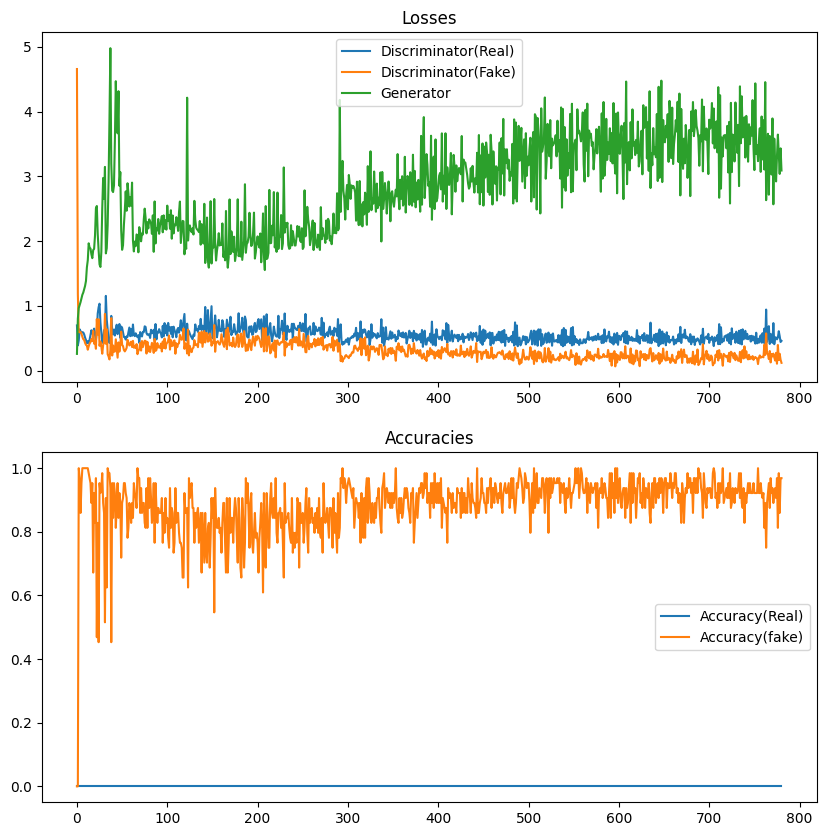

Iteration: 1
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 0.2503
Probabilitity of starting position being 1: 0.2631
Probabilitity of starting position being 2: 0.2424
Probabilitity of starting position being 3: 0.2442
Probability of action 0 being taken in state 0: 0.5135730512402763
Probability of action 1 being taken in state 0: 0.4462011519309759
Probability of action 2 being taken in state 1: 0.4668032132787147
Probability of action 3 being taken in state 1: 0.47773580890567646
Probability of action 4 being taken in state 2: 0.4858122457334391
Probability of action 5 being taken in state 2: 0.4768313589028478
Probability of action 6 being taken in state 3: 0.46540358293075684
Probability of action 7 being taken in state 3: 0.4848278985507246


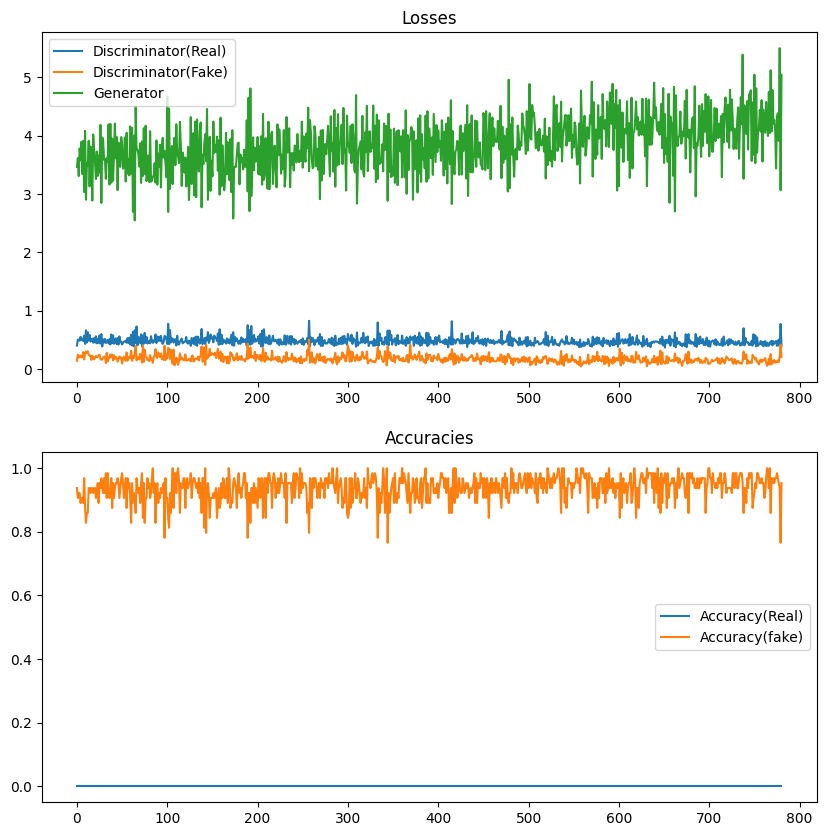

Iteration: 2
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 0.2662
Probabilitity of starting position being 1: 0.2436
Probabilitity of starting position being 2: 0.247
Probabilitity of starting position being 3: 0.2432
Probability of action 0 being taken in state 0: 0.5205991611743559
Probability of action 1 being taken in state 0: 0.4407429598562013
Probability of action 2 being taken in state 1: 0.45727574750830563
Probability of action 3 being taken in state 1: 0.49233222591362125
Probability of action 4 being taken in state 2: 0.49980318834875026
Probability of action 5 being taken in state 2: 0.46339303286754574
Probability of action 6 being taken in state 3: 0.44815259237038146
Probability of action 7 being taken in state 3: 0.5034498275086245


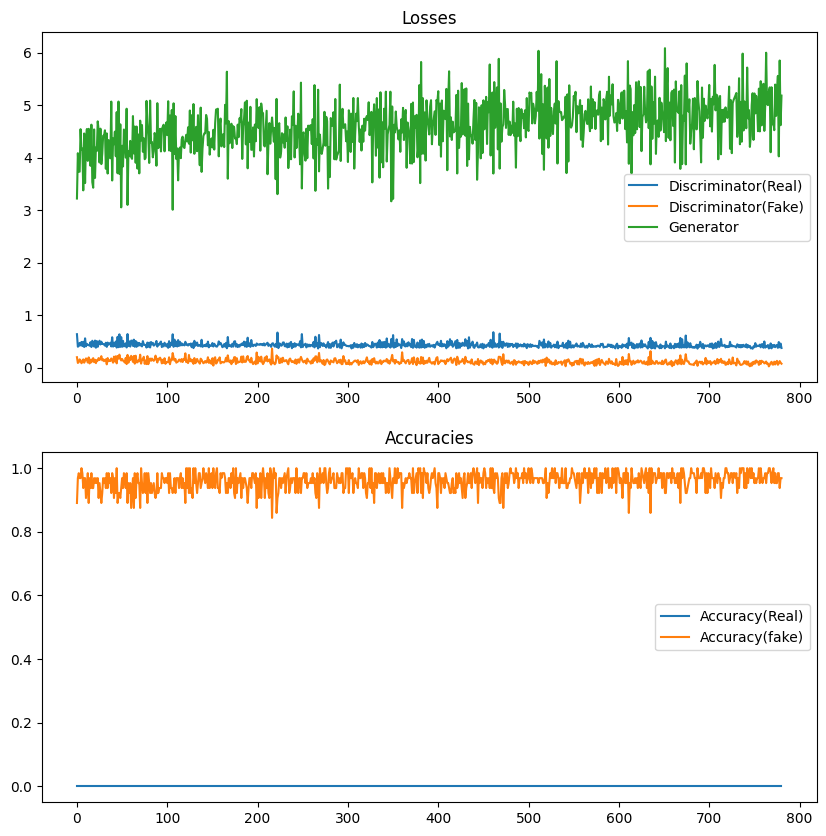

Iteration: 3
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 0.2554
Probabilitity of starting position being 1: 0.2512
Probabilitity of starting position being 2: 0.247
Probabilitity of starting position being 3: 0.2464
Probability of action 0 being taken in state 0: 0.5114007296466974
Probability of action 1 being taken in state 0: 0.4533650153609831
Probability of action 2 being taken in state 1: 0.41286000632978165
Probability of action 3 being taken in state 1: 0.5249235151387277
Probability of action 4 being taken in state 2: 0.46620317680241474
Probability of action 5 being taken in state 2: 0.49510119253797813
Probability of action 6 being taken in state 3: 0.40932953352332385
Probability of action 7 being taken in state 3: 0.5378981050947452


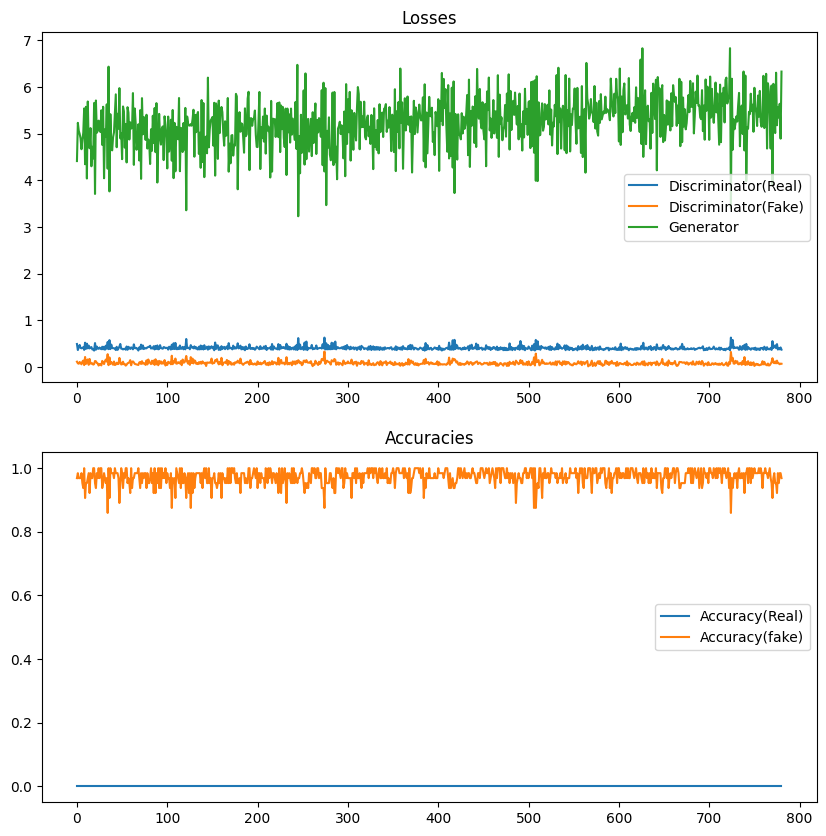

Iteration: 4
313/313 [==============================] - 1s 2ms/step
Probabilitity of starting position being 0: 0.2371
Probabilitity of starting position being 1: 0.2631
Probabilitity of starting position being 2: 0.2494
Probabilitity of starting position being 3: 0.2504
Probability of action 0 being taken in state 0: 0.48893424482368564
Probability of action 1 being taken in state 0: 0.4827128313578911
Probability of action 2 being taken in state 1: 0.3840839643948452
Probability of action 3 being taken in state 1: 0.5512156237544839
Probability of action 4 being taken in state 2: 0.44675362600992896
Probability of action 5 being taken in state 2: 0.5239706025503748
Probability of action 6 being taken in state 3: 0.40293545447829193
Probability of action 7 being taken in state 3: 0.5332085601004752


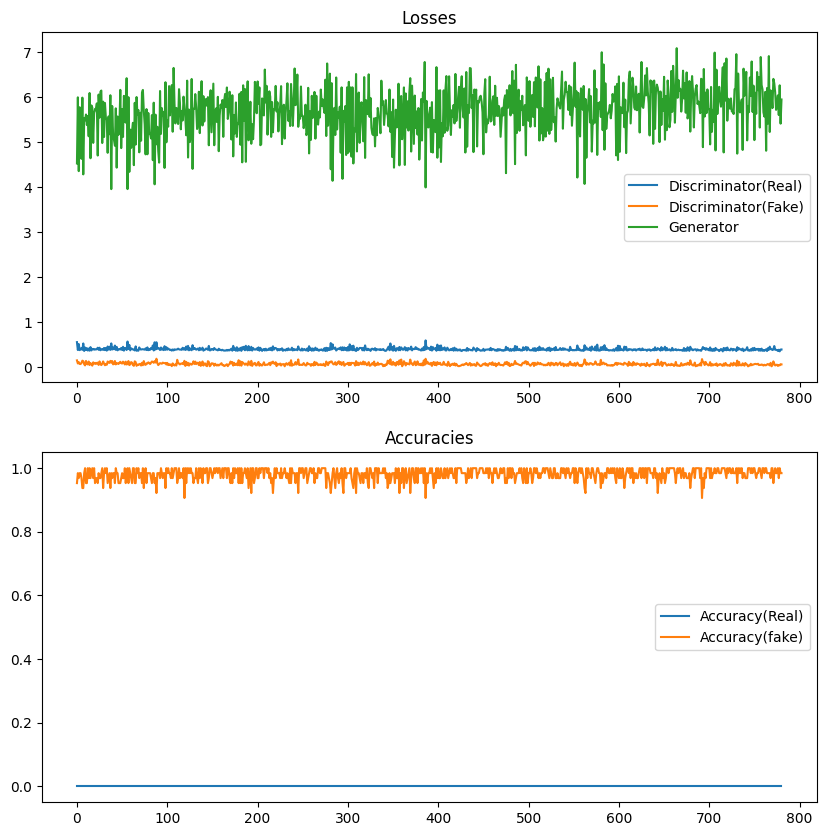

In [12]:
# tf.keras.config.disable_interactive_logging()
gan.train(epochs=5, batch_size=128, data_size=100000)

In [40]:
x, l,  _ = gan.generate_real_samples(10)
print(x[1])

[[ 1.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.1]
 [ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   1. ]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.4]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.4]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   1.   1. ]
 [ 1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1. ]
 [ 0.   1.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.  -0.2]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.3]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.3]
 [ 0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.   1. ]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.4]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   1.   0.   0.4]
 [ 0.   0.   0.   1.   0.   0.   0.   0.   0.   

In [15]:
gan.show_episode(x[0])

State: 3 Action: 6 Reward: 4.0
State: 3 Action: 6 Reward: 4.0
State: 3 Action: 6 Reward: 4.0
State: 3 Action: 7 Reward: 10.0
State: 0 Action: 0 Reward: 1.0
State: 0 Action: 1 Reward: 10.0
State: 1 Action: 3 Reward: 10.0
State: 2 Action: 5 Reward: 10.0
State: 3 Action: 6 Reward: 4.0
State: 3 Action: 6 Reward: -4.0
State: 0 Action: 0 Reward: 1.0
State: 0 Action: 0 Reward: 1.0
State: 0 Action: 0 Reward: 1.0
State: 0 Action: 1 Reward: 10.0
State: 1 Action: 3 Reward: 10.0
State: 2 Action: 4 Reward: 3.0


In [37]:
labels = np.ones((10, 1)) * 3
labels = tf.keras.utils.to_categorical(labels, num_classes=4)
x, _ = gan.generate_fake_samples(10, labels)

1/1 [==============================] - 0s 25ms/step


In [39]:
x = np.rint(x)
gan.show_episode(x[4])

State: 3 Action: 7 Reward: 10.0
State: 0 Action: 0 Reward: -0.0
State: 0 Action: 1 Reward: 10.0
State: 1 Action: 3 Reward: 10.0
State: 2 Action: 4 Reward: 0.0
State: 2 Action: 5 Reward: 10.0
State: 3 Action: 7 Reward: 10.0
State: 0 Action: 0 Reward: 0.0
State: 0 Action: 1 Reward: 10.0
State: 1 Action: 3 Reward: 10.0
State: 2 Action: 4 Reward: 10.0
State: 3 Action: 6 Reward: 0.0
State: 3 Action: 6 Reward: 10.0
State: 3 Action: 6 Reward: 0.0
State: 3 Action: 7 Reward: 10.0
State: 0 Action: 7 Reward: 10.0


In [34]:
print(x[0])


[[ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  1.]
 [ 1.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0. -0.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
 [ 0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  1.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.  1.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0. -0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  1.  0.  1.]]
